In [1]:
## Take past fantasy game data and calculate per plate appearance projections based only on current season performance

In [1]:
import pandas as pd
import os
import numpy as np
import math
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)

In [59]:
os.chdir('..')
cwd = os.getcwd()
os.chdir(cwd + '/Fantasy.2018-2021')

game_stats = pd.read_csv('PlayerGame.2020.csv')
game_stats.head()

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AtBats,Runs,Hits,Singles,Doubles,Triples,HomeRuns,RunsBattedIn,BattingAverage,Outs,Strikeouts,Walks,HitByPitch,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,StolenBases,CaughtStealing,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage
0,2902706,5,10002013,2,2020,Whit Merrifield,KC,CF,OF,1,NaN,59587,28,TEX,2/21/2020 12:00:00 AM,2/21/2020 3:05:00 PM,HOME,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2902707,5,10000542,2,2020,Alex Gordon,KC,LF,OF,1,NaN,59587,28,TEX,2/21/2020 12:00:00 AM,2/21/2020 3:05:00 PM,HOME,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2902708,5,10000525,2,2020,Salvador Perez,KC,DH,DH,1,NaN,59587,28,TEX,2/21/2020 12:00:00 AM,2/21/2020 3:05:00 PM,HOME,1,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2902709,5,10000225,2,2020,Jorge Soler,KC,RF,OF,1,NaN,59587,28,TEX,2/21/2020 12:00:00 AM,2/21/2020 3:05:00 PM,HOME,1,7.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.2,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2902710,5,10000953,2,2020,Maikel Franco,KC,3B,IF,1,NaN,59587,28,TEX,2/21/2020 12:00:00 AM,2/21/2020 3:05:00 PM,HOME,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
## Parse dataframe to only relevant data

# Select only regular season data
reg_season_game_stats = game_stats.loc[game_stats.SeasonType == 1].reset_index(drop=True)
# Select only batter data
reg_seas_batter_stats = reg_season_game_stats.loc[reg_season_game_stats.PositionCategory != 'P'].reset_index(drop=True)
# Calculate game by game plate appearances
reg_seas_batter_stats['PlateAppearances'] = reg_seas_batter_stats.apply(lambda row: row['AtBats'] + row['Walks'] + row['HitByPitch'] + row['Sacrifices'], axis=1)
# Remove players who appeared in a game, but did not record a PA
reg_seas_batter_stats_nozeros = reg_seas_batter_stats.loc[reg_seas_batter_stats.PlateAppearances > 0]
#reg_seas_batter_stats_nozeros['DraftKingsPointsPerPA'] = reg_seas_batter_stats_nozeros.apply(lambda row: row['FantasyPointsDraftKings'] / row['PlateAppearances'], axis=1)
data = reg_seas_batter_stats_nozeros
data = data.sort_values(['PlayerID', 'Day'], ascending=True).reset_index(drop=True)
data['Day'] = data['Day'].astype('datetime64[ns]')
data.rename(columns = {'Runs': 'R', 'Singles': 'S', 'Doubles': 'D', 'Triples': 'T', 'HomeRuns': 'HR', 'AtBats': 'AB', 'Walks':'BB', 'RunsBattedIn': 'RBI', 'PlateAppearances': 'PA', 'Hits': 'H', 'HitByPitch': 'HP', 'StolenBases': 'SB', 'CaughtStealing': 'CS', 'Strikeouts': 'SO'},  
          inplace = True) 
data.head()


,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [61]:
## Get list of PlayerID's and Days

players = list(data.PlayerID.unique())
days = data['Day'].tolist()
days = list(dict.fromkeys(days))
days.sort()

In [62]:
projections = {}

In [63]:
for day in days:
    player_dict = {}
    data_partial = data.loc[data.Day < day].reset_index(drop=True).groupby(['PlayerID']).mean()
    if data_partial.shape[0] == 0:
        player_id_list = players
        for player in player_id_list:
            player_dict[player] = np.NaN
            projections[day] = player_dict
    else:
        player_id_list = list(data_partial.index.values)
        for player in player_id_list:
            dkppa = data_partial.loc[player, : ]['FantasyPointsDraftKings'] / data_partial.loc[player, : ]['PA']
            player_dict[player] = dkppa
            
        projections[day] = player_dict

In [64]:
data['DraftKingsPointsPerPAActual'] = data.apply(lambda row: row['FantasyPointsDraftKings'] / row['PA'], axis=1)
data['InSeasonProjDKPPA'] = data.apply(lambda row: projections[row['Day']][row['PlayerID']] if row['PlayerID'] in projections[row['Day']] else np.NaN, axis=1)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5


In [65]:
# Get projections file
os.chdir('..')
cwd = os.getcwd()
os.chdir(cwd + '/BaselineProjections')

In [66]:
marcels = pd.read_csv('marcel_batters_2020.csv')

In [67]:
marcels.head()

,bdbID,First,Last,Year,age,rel,DraftKingsPoints,DKp/PA,wOBA,AVG,OBP,SLG,PA,AB,R,H,D,T,HR,RBI,SB,CS,BB,SO,IBB,HP,SH,SF,GDP
0,lindofr01,Francisco,Lindor,2020,27,0.88,1292,2.146,0.374,0.281,0.346,0.527,602,541,95,152,36,2,31,75,17,5,51,91,6,5,2,4,9
1,bregmal01,Alex,Bregman,2020,26,0.87,1369,2.222,0.408,0.291,0.396,0.551,616,519,99,151,38,2,31,92,9,3,84,85,2,9,0,5,11
2,beninan01,Andrew,Benintendi,2020,26,0.87,1122,1.955,0.359,0.280,0.357,0.456,574,504,79,141,33,4,16,75,13,3,59,110,2,5,2,6,9
3,rizzoan01,Anthony,Rizzo,2020,31,0.87,1173,2.047,0.387,0.281,0.384,0.498,573,484,77,136,26,2,25,88,6,3,65,83,7,19,0,4,13
4,santaca01,Carlos,Santana,2020,34,0.87,1174,1.921,0.367,0.256,0.363,0.470,611,515,86,132,28,2,26,79,4,1,87,97,7,3,0,4,11


In [68]:
## Quick detour to add pure pre season projections

marcels['Name'] = marcels.apply(lambda row: row['First'] + ' ' + row['Last'], axis=1)
marcels.rename(columns = {'DKp/PA': 'PreSeasonProjDKPPA'}, inplace = True)
dkpa = marcels[['Name', 'PreSeasonProjDKPPA']]
data = data.merge(dkpa, how='left', on='Name')
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784


In [69]:
## Quick detour to add pure pre season projections

marcels['Name'] = marcels.apply(lambda row: row['First'] + ' ' + row['Last'], axis=1)
marcels.rename(columns = {'rel': 'Reliability'}, inplace = True)
dkpa = marcels[['Name', 'Reliability']]
data = data.merge(dkpa, how='left', on='Name')
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784,0.83
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784,0.83
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784,0.83
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784,0.83
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784,0.83


In [70]:
reliability_dict = {}

for index, row in data.iterrows():
    if math.isnan(row['Reliability']) == True:
        reliability_dict[row['PlayerID']] = 0
    else:
        reliability_dict[row['PlayerID']] = row['Reliability']

In [71]:

projections_2 = {}
for day in days:
    player_dict = {}
    data_partial = data.loc[data.Day < day].reset_index(drop=True).groupby(['PlayerID']).sum()
    if data_partial.shape[0] == 0: pass
        #player_id_list = players
        #for player in player_id_list:
        #    player_dict[player] = np.NaN
        #    projections[day] = player_dict
    else:
        player_id_list = list(data_partial.index.values)
        for player in player_id_list:
            player_dict[player] = {}
            for stat in ['PA', 'AB', 'R', 'H', 'S', 'D', 'T', 'HR', 'RBI', 'BB', 'HP', 'SB', 'CS', 'SO']:
                value = data_partial.loc[player, stat]
                player_dict[player][stat] = value
                
            # player totals
            PA = player_dict[player]['PA']
            BB = player_dict[player]['BB']
            K = player_dict[player]['SO']
            HBP = player_dict[player]['HP']
            HR = player_dict[player]['HR']
            S = player_dict[player]['S']
            D = player_dict[player]['D']
            T = player_dict[player]['T']
            
            rel = reliability_dict[player]
            rel_fact = (2.2 ** rel) / 2
            
            player_dict[player]['BB_s'] = PA / (PA + (120 * rel_fact)) #!!! prior 120 PA should be 50% of the rate!!!
            player_dict[player]['HBP_s'] = PA / (PA + (240 * rel_fact))
            #player_dict[player]['S_s'] = (PA-HBP-K-BB-HR) / ((PA-HBP-K-BB-HR) + 959)
            player_dict[player]['S_s'] = PA / (PA + (290 * rel_fact))
            player_dict[player]['D_s'] = (D + T) / ((D + T) + (48 * rel_fact))
            player_dict[player]['T_s'] = (D + T) / ((D + T) + (48 * rel_fact))
            #player_dict[player]['HR_s'] = (PA-K-BB-HBP) / ((PA-K-BB-HBP) + 143)
            player_dict[player]['HR_s'] = PA / (PA + (170 * rel_fact))
            player_dict[player]['R_s'] = PA / (PA + (300 * rel_fact))
            player_dict[player]['RBI_s'] = PA / (PA + (300 * rel_fact))
            player_dict[player]['SBA_s'] = (S + BB + HBP) / ((S + BB + HBP) + (39 * rel_fact))

                
        projections_2[day] = player_dict

In [72]:
projections_2[days[45]]

{10000029: {'PA': 150.0,
  'AB': 138.0,
  'R': 19.0,
  'H': 33.0,
  'S': 22.0,
  'D': 7.0,
  'T': 0.0,
  'HR': 4.0,
  'RBI': 20.0,
  'BB': 12.0,
  'HP': 0.0,
  'SB': 2.0,
  'CS': 0.0,
  'SO': 33.0,
  'BB_s': 0.5650961994687657,
  'HBP_s': 0.3938216619536125,
  'S_s': 0.3496636365237717,
  'D_s': 0.13163681770267205,
  'T_s': 0.13163681770267205,
  'HR_s': 0.4784045506132846,
  'R_s': 0.34199428076911464,
  'RBI_s': 0.34199428076911464,
  'SBA_s': 0.4754014870046803},
 10000030: {'PA': 49.0,
  'AB': 46.0,
  'R': 3.0,
  'H': 7.0,
  'S': 6.0,
  'D': 1.0,
  'T': 0.0,
  'HR': 0.0,
  'RBI': 1.0,
  'BB': 2.0,
  'HP': 0.0,
  'SB': 0.0,
  'CS': 0.0,
  'SO': 9.0,
  'BB_s': 0.30796797533285025,
  'HBP_s': 0.1820107248817779,
  'S_s': 0.15550963817284064,
  'D_s': 0.022201017294922583,
  'T_s': 0.022201017294922583,
  'HR_s': 0.23904123078363188,
  'R_s': 0.15110928189213274,
  'RBI_s': 0.15110928189213274,
  'SBA_s': 0.18271129933474073},
 10000031: {'PA': 125.0,
  'AB': 96.0,
  'R': 20.0,
  'H':

In [73]:
#marcels['Name'] = marcels.apply(lambda row: row['First'] + ' ' + row['Last'], axis=1)
data_ID = data[['PlayerID', 'Name']].drop_duplicates()
marcels = marcels.merge(data_ID, how='left', on='Name')
marcels = marcels[marcels['PlayerID'].notna()]
marcels.head()

,bdbID,First,Last,Year,age,Reliability,DraftKingsPoints,PreSeasonProjDKPPA,wOBA,AVG,OBP,SLG,PA,AB,R,H,D,T,HR,RBI,SB,CS,BB,SO,IBB,HP,SH,SF,GDP,Name,PlayerID
0,lindofr01,Francisco,Lindor,2020,27,0.88,1292,2.146,0.374,0.281,0.346,0.527,602,541,95,152,36,2,31,75,17,5,51,91,6,5,2,4,9,Francisco Lindor,10001911.0
1,bregmal01,Alex,Bregman,2020,26,0.87,1369,2.222,0.408,0.291,0.396,0.551,616,519,99,151,38,2,31,92,9,3,84,85,2,9,0,5,11,Alex Bregman,10005589.0
2,beninan01,Andrew,Benintendi,2020,26,0.87,1122,1.955,0.359,0.280,0.357,0.456,574,504,79,141,33,4,16,75,13,3,59,110,2,5,2,6,9,Andrew Benintendi,10005530.0
3,rizzoan01,Anthony,Rizzo,2020,31,0.87,1173,2.047,0.387,0.281,0.384,0.498,573,484,77,136,26,2,25,88,6,3,65,83,7,19,0,4,13,Anthony Rizzo,10000217.0
4,santaca01,Carlos,Santana,2020,34,0.87,1174,1.921,0.367,0.256,0.363,0.470,611,515,86,132,28,2,26,79,4,1,87,97,7,3,0,4,11,Carlos Santana,10000353.0


In [74]:
marcels = marcels.set_index('PlayerID')
rel_columns = marcels.columns.to_list()[12:29]
marcels = marcels[rel_columns]
marcels = marcels.div(marcels.PA, axis=0)
marcels['S'] = marcels.apply(lambda row: row['H'] - row['D'] - row['T'] - row['HR'], axis=1)
marcels.head()
    

,PA,AB,R,H,D,T,HR,RBI,SB,CS,BB,SO,IBB,HP,SH,SF,GDP,S
PlayerID,,,,,,,,,,,,,,,,,,
10001911.0,1.0,0.898671,0.157807,0.252492,0.059801,0.003322,0.051495,0.124585,0.028239,0.008306,0.084718,0.151163,0.009967,0.008306,0.003322,0.006645,0.014950,0.137874
10005589.0,1.0,0.842532,0.160714,0.245130,0.061688,0.003247,0.050325,0.149351,0.014610,0.004870,0.136364,0.137987,0.003247,0.014610,0.000000,0.008117,0.017857,0.129870
10005530.0,1.0,0.878049,0.137631,0.245645,0.057491,0.006969,0.027875,0.130662,0.022648,0.005226,0.102787,0.191638,0.003484,0.008711,0.003484,0.010453,0.015679,0.153310
10000217.0,1.0,0.844677,0.134380,0.237347,0.045375,0.003490,0.043630,0.153578,0.010471,0.005236,0.113438,0.144852,0.012216,0.033159,0.000000,0.006981,0.022688,0.144852
10000353.0,1.0,0.842881,0.140753,0.216039,0.045827,0.003273,0.042553,0.129296,0.006547,0.001637,0.142390,0.158756,0.011457,0.004910,0.000000,0.006547,0.018003,0.124386


In [75]:
players = marcels.index.to_list()


In [76]:
marcels_dict = marcels.to_dict('index')

In [77]:
#############
#THIS IS THE OLD WAY

## Blended projections dictionary
## This is mostly for backtesting. In season should be easier to calculate
## Should return per plate appearance rates for all relevant stats

######
# For players with no marcels projections, what do we need to do?

blended_dict = {}

for day in days[1:]:

    player_projs_dict = {}

    for player in players:
        
        try:
            player_dict = projections_2[day][player]
        except: continue
        
        new_player_dict = {}

        PA = player_dict['PA']
        new_player_dict['PA'] = PA

        stat_list = ['R', 'S', 'D', 'T', 'HR', 'RBI', 'BB', 'HP', 'SB']
        stab_list = ['R_s', 'S_s', 'D_s', 'T_s', 'HR_s', 'RBI_s', 'HBP_s', 'SBA_s']
        i = 0

        for stat in stat_list:

            if stat == 'SB':

                opps = player_dict['S'] + player_dict['HP'] + player_dict['BB']
                sba_exp = (marcels_dict[player][stat] + marcels_dict[player]['CS']) / (marcels_dict[player]['S'] + marcels_dict[player]['BB'] + marcels_dict[player]['HP'])
                if opps == 0:
                    sba_act = 0
                else:
                    sba_act = (player_dict[stat] + player_dict['CS']) / opps
                sba_blend = (sba_act * player_dict['SBA_s']) + (sba_exp * (1 - player_dict['SBA_s']))
                succ_rate_proj = marcels_dict[player][stat] / (marcels_dict[player][stat] + marcels_dict[player]['CS'])

            else:

                stat_exp = marcels_dict[player][stat] * PA
                stat_act = player_dict[stat]
                stat_blend = (stat_act * player_dict[stab_list[i]]) + (stat_exp * (1 - player_dict[stab_list[i]]))

                new_player_dict[stat_list[i]] = stat_blend

                i += 1

        hits = new_player_dict['S'] + new_player_dict['D'] + new_player_dict['T'] + new_player_dict['HR']
        new_player_dict['AB'] = new_player_dict['PA'] - new_player_dict['BB'] - new_player_dict['HP']
        new_player_dict['SB'] = sba_blend * succ_rate_proj * (new_player_dict['S'] + new_player_dict['BB'] - new_player_dict['HP'])
        
        ## This is our projection for the date based on combo of pre season projection and current season performance
        
        new_player_dict['DKP/PA'] = ((3 * new_player_dict['S']) + (5 * new_player_dict['D']) + (8 * new_player_dict['T']) + (10 * new_player_dict['HR']) + (2 * new_player_dict['RBI']) + (2 * new_player_dict['R']) + (2 * new_player_dict['BB']) + (2 * new_player_dict['HP']) + (5 * new_player_dict['SB'])) / PA

        player_projs_dict[player] = new_player_dict

    blended_dict[day] = player_projs_dict


In [78]:
blended_dict[days[1]]

{10000176.0: {'PA': 5.0,
  'R': 0.9135041167109076,
  'S': 0.7214496221519372,
  'D': 0.3175895765472313,
  'T': 0.03257328990228013,
  'HR': 0.21354369359921244,
  'RBI': 0.6407102465858694,
  'BB': 0.606172790692026,
  'HP': 0.031753230021430684,
  'AB': 4.362073979286543,
  'SB': 0.14286694765180313,
  'DKP/PA': 2.249387102136363},
 10000870.0: {'PA': 3.0,
  'R': 0.4377204930361946,
  'S': 0.3877192385869528,
  'D': 0.12313432835820895,
  'T': 0.02798507462686567,
  'HR': 0.10447166503647076,
  'RBI': 0.31028288113958097,
  'BB': 0.2929246214127353,
  'HP': 0.02798507462686567,
  'AB': 2.679090303960399,
  'SB': 0.06118676112870209,
  'DKP/PA': 1.8303955170019333},
 10003122.0: {'PA': 5.0,
  'R': 0.8042671706608024,
  'S': 0.6380728040295477,
  'D': 0.2601666831369045,
  'T': 0.033028273074245336,
  'HR': 0.3029280499750385,
  'RBI': 0.7876843423997549,
  'BB': 0.6317347552221646,
  'HP': 0.02465337096584059,
  'AB': 4.343611873811994,
  'SB': 0.09456347081192029,
  'DKP/PA': 2.2956

In [79]:
## Now we need to figure out TotalSeasonPA
total_season_pa_dict = {}

for day in days:
    day_dict = {}
    data_partial = data.loc[data.Day < day].reset_index(drop=True)
    player_id_list = list(data_partial.PlayerID.unique())
    for player in player_id_list:
        season_pa = data_partial.loc[data_partial.PlayerID == player, 'PA'].sum()
        day_dict[player] = season_pa
        
    total_season_pa_dict[day] = day_dict
    
data['TotalSeasonPA'] = data.apply(lambda row: total_season_pa_dict[row['Day']][row['PlayerID']] if row['PlayerID'] in total_season_pa_dict[row['Day']] else 0, axis=1)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,TotalSeasonPA
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784,0.83,0.0
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784,0.83,3.0
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784,0.83,6.0
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784,0.83,10.0
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784,0.83,14.0


In [80]:
data = data[data['Day'] != days[0]].reset_index(drop=True)

In [81]:
data['BlendedProjDKPPA'] = data.apply(lambda row: blended_dict[row['Day']][row['PlayerID']]['DKP/PA'] if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pS/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['S'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pD/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['D'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pT/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['T'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pHR/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['HR'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pBB/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['BB'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pHP/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['HP'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)
data['pSB/PA'] = data.apply(lambda row: round((blended_dict[row['Day']][row['PlayerID']]['SB'], 3) if row['PlayerID'] in blended_dict[row['Day']] else np.NaN, axis=1)




In [82]:
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,TotalSeasonPA,BlendedProjDKPPA,pR,pS,pD,pT,pHR,pBB,pHP,pRBI,pSB
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784,0.83,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784,0.83,3.0,1.762443,0.365,0.381,0.158,0.026,0.098,0.234,0.021,0.386,0.029
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784,0.83,6.0,1.744982,0.482,0.502,0.211,0.035,0.129,0.308,0.028,0.510,0.038
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784,0.83,10.0,1.730144,0.476,0.495,0.211,0.035,0.126,0.320,0.027,0.503,0.038
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784,0.83,14.0,1.724349,0.483,0.502,0.211,0.035,0.123,0.315,0.027,0.496,0.037


In [26]:
## HOLD
data = data[data['TotalSeasonPA'].notna()].reset_index(drop=True)
data['pa_group'] = data.apply(lambda row: math.floor(row['TotalSeasonPA'] / 10), axis=1)

In [27]:
## HOLD
data = data[data['Reliability'].notna()].reset_index(drop=True)
data['rel_group'] = data.apply(lambda row: math.floor(row['Reliability'] * 10), axis=1)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,BlendedProjDKPPA,pR,pS,pD,pT,pHR,pBB,pHP,pRBI,pSB,TotalSeasonPA,pa_group,rel_group
0,2162023,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50618,23,COL,2018-03-30,3/30/2018 9:40:00 PM,HOME,1,12.0,4.0,1.0,3.0,2.0,0.0,0.0,1.0,5.0,0.750,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.500,2.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.7,28.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.00,2.750,1.562,0.74,1.582227,0.473,0.579,0.182,0.024,0.097,0.276,0.024,0.370,0.046,0.0,0,7
1,2165293,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50634,23,COL,2018-03-31,3/31/2018 8:10:00 PM,HOME,1,3.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.250,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.25,0.500,0.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.5,7.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.75,4.875,1.562,0.74,1.672500,0.480,0.600,0.170,0.024,0.120,0.271,0.023,0.436,0.045,4.0,0,7
2,2188297,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50759,15,SF,2018-04-10,4/10/2018 10:15:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,2.500,1.562,0.74,1.643539,0.461,0.600,0.180,0.023,0.107,0.282,0.020,0.447,0.040,24.0,2,7
3,2190565,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50773,15,SF,2018-04-11,4/11/2018 3:45:00 PM,AWAY,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.00,2.250,1.562,0.74,1.625845,0.455,0.592,0.176,0.023,0.104,0.293,0.020,0.441,0.039,28.0,2,7
4,2194596,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50792,1,LAD,2018-04-13,4/13/2018 10:10:00 PM,AWAY,1,7.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.333,1.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.7,16.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.00,2.000,1.562,0.74,1.601971,0.449,0.584,0.174,0.023,0.102,0.289,0.020,0.436,0.039,32.0,3,7


In [83]:
data['playergameID'] = data.apply(lambda row: str(row['PlayerID']) + str(row['GameID']), axis=1)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,TotalSeasonPA,BlendedProjDKPPA,pR,pS,pD,pT,pHR,pBB,pHP,pRBI,pSB,playergameID
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784,0.83,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000002959635
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784,0.83,3.0,1.762443,0.365,0.381,0.158,0.026,0.098,0.234,0.021,0.386,0.029,1000002959652
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784,0.83,6.0,1.744982,0.482,0.502,0.211,0.035,0.129,0.308,0.028,0.510,0.038,1000002959665
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784,0.83,10.0,1.730144,0.476,0.495,0.211,0.035,0.126,0.320,0.027,0.503,0.038,1000002959669
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784,0.83,14.0,1.724349,0.483,0.502,0.211,0.035,0.123,0.315,0.027,0.496,0.037,1000002959691


In [84]:
## Calculate projected team OBP prior to the current game

#gameid = data.loc[1]['GameID']
#teamid = data.loc[1]['TeamID']
#playerid = data.loc[1]['PlayerID']
#sub_df = data[(data['GameID'] == gameid) & (data['TeamID'] == teamid) & (data['Started'] == 1) & (data['PlayerID'] != playerid)].reset_index(drop=True)
#sub_df = sub_df[sub_df.BlendedProjDKPPA.notna()].reset_index(drop=True)
#tOBP = (sub_df.pS.sum() + sub_df.pD.sum() + sub_df.pT.sum() + sub_df.pHR.sum() + sub_df.pBB.sum() + sub_df.pHP.sum()) / sub_df.PA.sum()
#tOBP

tOBP_dict = {}

for index, row in data.iterrows():
    
    playergameid = row['playergameID']
    gameid = row['GameID']
    teamid = row['TeamID']
    playerid = row['PlayerID']
    
    sub_df = data[(data['GameID'] == gameid) & (data['TeamID'] == teamid) & (data['Started'] == 1) & (data['PlayerID'] != playerid)].reset_index(drop=True)
    sub_df = sub_df[sub_df.BlendedProjDKPPA.notna()].reset_index(drop=True)
    OB_events = sub_df.pS.sum() + sub_df.pD.sum() + sub_df.pT.sum() + sub_df.pHR.sum() + sub_df.pBB.sum() + sub_df.pHP.sum()
    denominator_PA = sub_df.PA.sum()
    if denominator_PA == 0: continue
    else:
        tOBP = OB_events / denominator_PA
    
    tOBP_dict[playergameid] = tOBP
    

In [85]:
data['teamProjectedOBP'] = data.apply(lambda row: tOBP_dict[row['playergameID']] if row['playergameID'] in tOBP_dict else np.NaN, axis=1)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,TotalSeasonPA,BlendedProjDKPPA,pR,pS,pD,pT,pHR,pBB,pHP,pRBI,pSB,playergameID,teamProjectedOBP
0,2954984,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59635,33,SD,2020-07-24,7/24/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,NaN,1.784,0.83,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000002959635,NaN
1,2959902,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59652,33,SD,2020-07-25,7/25/2020 9:10:00 PM,AWAY,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,1.784,0.83,3.0,1.762443,0.365,0.381,0.158,0.026,0.098,0.234,0.021,0.386,0.029,1000002959652,0.336444
2,2962394,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59665,33,SD,2020-07-26,7/26/2020 4:10:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,0.0,1.784,0.83,6.0,1.744982,0.482,0.502,0.211,0.035,0.129,0.308,0.028,0.510,0.038,1000002959665,0.331152
3,2964569,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59669,33,SD,2020-07-27,7/27/2020 4:10:00 PM,AWAY,1,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.250,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.250,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.2,1.784,0.83,10.0,1.730144,0.476,0.495,0.211,0.035,0.126,0.320,0.027,0.503,0.038,1000002959669,0.332313
4,2967354,14,10000029,1,2020,Nick Ahmed,ARI,SS,IF,1,NaN,59691,28,TEX,2020-07-28,7/28/2020 9:05:00 PM,AWAY,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.333,0.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,0.5,1.784,0.83,14.0,1.724349,0.483,0.502,0.211,0.035,0.123,0.315,0.027,0.496,0.037,1000002959691,0.331528


In [86]:
#all_dfs = []
all_dfs.append(data)
len(all_dfs)

3

In [89]:
#new_data = pd.concat(all_dfs, axis=0)
new_data.to_csv('gamedatawteamobp.csv', index=False)
#new_data.head()

In [34]:
data = data[data['pa_group'] < 60].reset_index(drop=True)
data.head()

,StatID,TeamID,PlayerID,SeasonType,Season,Name,Team,Position,PositionCategory,Started,InjuryStatus,GameID,OpponentID,Opponent,Day,DateTime,HomeOrAway,Games,FantasyPoints,AB,R,H,S,D,T,HR,RBI,BattingAverage,Outs,SO,BB,HP,Sacrifices,SacrificeFlies,GroundIntoDoublePlay,SB,CS,OnBasePercentage,SluggingPercentage,OnBasePlusSlugging,Wins,Losses,Saves,InningsPitchedDecimal,TotalOutsPitched,InningsPitchedFull,InningsPitchedOuts,EarnedRunAverage,PitchingHits,PitchingRuns,PitchingEarnedRuns,PitchingWalks,PitchingStrikeouts,PitchingHomeRuns,PitchesThrown,PitchesThrownStrikes,WalksHitsPerInningsPitched,PitchingBattingAverageAgainst,FantasyPointsFanDuel,FantasyPointsDraftKings,WeightedOnBasePercentage,PitchingCompleteGames,PitchingShutOuts,PitchingOnBasePercentage,PitchingSluggingPercentage,PitchingOnBasePlusSlugging,PitchingStrikeoutsPerNineInnings,PitchingWalksPerNineInnings,PitchingWeightedOnBasePercentage,PA,DraftKingsPointsPerPAActual,InSeasonProjDKPPA,PreSeasonProjDKPPA,Reliability,BlendedProjDKPPA,pR,pS,pD,pT,pHR,pBB,pHP,pRBI,pSB,TotalSeasonPA,pa_group,rel_group
0,2162023,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50618,23,COL,2018-03-30,3/30/2018 9:40:00 PM,HOME,1,12.0,4.0,1.0,3.0,2.0,0.0,0.0,1.0,5.0,0.750,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.500,2.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.7,28.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.00,2.750,1.562,0.74,1.582227,0.47,0.58,0.18,0.02,0.10,0.28,0.02,0.37,0.05,0.0,0,7
1,2165293,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50634,23,COL,2018-03-31,3/31/2018 8:10:00 PM,HOME,1,3.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.250,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.25,0.500,0.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.5,7.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.75,4.875,1.562,0.74,1.672500,0.48,0.60,0.17,0.02,0.12,0.27,0.02,0.44,0.04,4.0,0,7
2,2188297,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50759,15,SF,2018-04-10,4/10/2018 10:15:00 PM,AWAY,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.25,0.000,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50,2.500,1.562,0.74,1.643539,0.46,0.60,0.18,0.02,0.11,0.28,0.02,0.45,0.04,24.0,2,7
3,2190565,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50773,15,SF,2018-04-11,4/11/2018 3:45:00 PM,AWAY,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.00,2.250,1.562,0.74,1.625845,0.46,0.59,0.18,0.02,0.10,0.29,0.02,0.44,0.04,28.0,2,7
4,2194596,14,10000029,1,2018,Nick Ahmed,ARI,SS,IF,1,NaN,50792,1,LAD,2018-04-13,4/13/2018 10:10:00 PM,AWAY,1,7.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.333,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.333,1.833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.7,16.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.00,2.000,1.562,0.74,1.601971,0.45,0.58,0.17,0.02,0.10,0.29,0.02,0.44,0.04,32.0,3,7


In [37]:
## Working on splitting players into groups to see at what point in season performance overtakes
## the blended model in RMSE accuracy
#from scipy.stats import pearsonr

rmse_dict = {}
rmse_summary = {}

def calculate_rmse(batters_df):
    
    nonan_df = batters_df[(batters_df['PreSeasonProjDKPPA'].notna()) & (batters_df['InSeasonProjDKPPA'].notna())]
    
    #dates_list = list(nonan_df.Day.unique())
    groups_list = list(nonan_df.pa_group.unique())
    #pa_list = list(nonan_df.TotalSeasonPA.unique())
    #rel_groups_list = list(nonan_df.rel_group.unique())
    
    for group in groups_list:
        
        #print(date)
        day_df = nonan_df.loc[nonan_df['pa_group'] == group].reset_index(drop=True)
        
        ## This is new stuff
        dkactual = list(day_df.DraftKingsPointsPerPAActual)
        inseason_only = list(day_df.InSeasonProjDKPPA)
        preseas_only = list(day_df.PreSeasonProjDKPPA)
        blended = list(day_df.BlendedProjDKPPA)
        
        # Component statistics
        pR = list(day_df.pR)
        pS = list(day_df.pS)
        pD = list(day_df.pD)
        pT = list(day_df.pT)
        pHR = list(day_df.pHR)
        pRBI = list(day_df.pRBI)
        pBB = list(day_df.pBB)
        pHP = list(day_df.pHP)
        pSB = list(day_df.pSB)
        
        # Actual Statistics
        aR = list(day_df.R)
        aS = list(day_df.S)
        aD = list(day_df.D)
        aT = list(day_df.T)
        aHR = list(day_df.HR)
        aRBI = list(day_df.RBI)
        aBB = list(day_df.BB)
        aHP = list(day_df.HP)
        aSB = list(day_df.SB)
        
        
        corr_inseason_only, p_value_inseason = pearsonr(dkactual, inseason_only)
        corr_preseas_only, p_value_preseason = pearsonr(dkactual, preseas_only)
        corr_blended, p_value_blended = pearsonr(dkactual, blended)
        
        cR, pR = pearsonr(aR, pR)
        cS, pS = pearsonr(aS, pS)
        cD, pD = pearsonr(aD, pD)
        cT, pT = pearsonr(aT, pT)
        cHR, pHR = pearsonr(aHR, pHR)
        cRBI, pRBI = pearsonr(aRBI, pRBI)
        cBB, pBB = pearsonr(aBB, pBB)
        cHP, pHP = pearsonr(aHP, pHP)
        cSB, pSB = pearsonr(aSB, pSB)
        
        #total_pa = day_df.PA.sum()
        #day_df['w'] = day_df.apply(lambda row: row['PA'] / total_pa, axis=1)
        #day_df['obs_dkpa'] = day_df.apply(lambda row: row['draft_kings_points'] / row['PA'], axis=1)
        #day_df['is_err'] = day_df.apply(lambda row: row['InSeasonProjDKPPA'] - row['DraftKingsPointsPerPAActual'], axis=1)
        #day_df['ps_err'] = day_df.apply(lambda row: row['PreSeasonProjDKPPA'] - row['DraftKingsPointsPerPAActual'], axis=1)
        #day_df['b_err'] = day_df.apply(lambda row: row['BlendedProjDKPPA'] - row['DraftKingsPointsPerPAActual'], axis=1)
        #day_df['is_sq_err'] = day_df.apply(lambda row: row['is_err'] ** 2, axis=1)
        #day_df['ps_sq_err'] = day_df.apply(lambda row: row['ps_err'] ** 2, axis=1)
        #day_df['b_sq_err'] = day_df.apply(lambda row: row['b_err'] ** 2, axis=1)
        
        #day_df['is_weighted_sq_err'] = day_df.apply(lambda row: row['is_sq_err'] * row['w'], axis=1)
        #day_df['ps_weighted_sq_err'] = day_df.apply(lambda row: row['ps_sq_err'] * row['w'], axis=1)
        #day_df['b_weighted_sq_err'] = day_df.apply(lambda row: row['b_sq_err'] * row['w'], axis=1)
        
        #is_rmse = math.sqrt(sum(day_df['is_weighted_sq_err']))
        #ps_rmse = math.sqrt(sum(day_df['ps_weighted_sq_err']))
        #b_rmse = math.sqrt(sum(day_df['b_weighted_sq_err']))
        
        rmse_summary[group] = {'inseason': round(corr_inseason_only, 3), 
                               'preseason': round(corr_preseas_only, 3), 
                               'blended': round(corr_blended, 3),
                               'cR': round(cR, 3),
                               'cS': round(cS, 3),
                               'cD': round(cD, 3),
                               'cT': round(cT, 3),
                               'cHR': round(cHR, 3),
                               'cRBI': round(cRBI, 3),
                               'cBB': round(cBB, 3),
                               'cSB': round(cSB, 3),
                               'cHP': round(cHP, 3)
                              }
        
    return rmse_summary

In [38]:
rmse_dict = calculate_rmse(data)

In [39]:
y_values_ins = []
y_values_pre = []
y_values_blend = []
y_values_r = []
y_values_d = []
y_values_t = []
y_values_hr = []
y_values_rbi = []
y_values_bb = []
y_values_hp = []
y_values_sb = []
y_values_s = []

k = list(rmse_dict.keys())
k.sort()
for i in k: 
    y_values_ins.append(rmse_dict[i]['inseason'])
    y_values_pre.append(rmse_dict[i]['preseason'])
    y_values_blend.append(rmse_dict[i]['blended'])
    y_values_r.append(rmse_dict[i]['cR'])
    y_values_s.append(rmse_dict[i]['cS'])
    y_values_d.append(rmse_dict[i]['cD'])
    y_values_t.append(rmse_dict[i]['cT'])
    y_values_hr.append(rmse_dict[i]['cHR'])
    y_values_bb.append(rmse_dict[i]['cRBI'])
    y_values_hp.append(rmse_dict[i]['cBB'])
    y_values_rbi.append(rmse_dict[i]['cHP'])
    y_values_sb.append(rmse_dict[i]['cSB'])
    
y1 = np.array(y_values_ins)
y2 = np.array(y_values_pre)
y3 = np.array(y_values_blend)
y4 = np.array(y_values_r)
y5 = np.array(y_values_s)
y6 = np.array(y_values_d)
y7 = np.array(y_values_t)
y8 = np.array(y_values_hr)
y9 = np.array(y_values_rbi)
y10 = np.array(y_values_bb)
y11 = np.array(y_values_hp)
y12 = np.array(y_values_sb)

x_values = list(rmse_dict.keys())
#x_values.reverse()
x = np.arange(len(x_values))

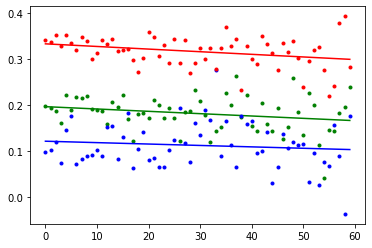

In [45]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Fit with polyfit
#i_b, i_m = polyfit(x, y1, 1)
#p_b, p_m = polyfit(x, y2, 1)
#b_b, b_m = polyfit(x, y3, 1)
b, m = polyfit(x, y4, 1)
b1, m1 = polyfit(x, y9, 1)
b2, m2 = polyfit(x, y8, 1)


plt.plot(x, y8, '.', color='green')
plt.plot(x, b2 + m2 * x, '-', color='green')
plt.plot(x, y9, '.', color='blue')
plt.plot(x, b1 + m1 * x, '-', color='blue')
plt.plot(x, y4, '.', color='red')
plt.plot(x, b + m * x, '-', color='red')
plt.show()

In [194]:
# Need a count of each day each projection type is the best

in_s = 0
pre_s = 0
blend = 0

for i in range(len(x)):
    a = y1[i]
    b = y2[i]
    c = y3[i]
    
    if a > b:
        if a > c:
            in_s += 1
        else:
            blend += 1
    else:
        if b > c:
            pre_s += 1
        else:
            blend += 1
            
print('Preseason: ' + str(pre_s) + ', in season: ' + str(in_s) + ', blend: ' + str(blend))
            

Preseason: 23, in season: 13, blend: 24


In [ ]:
## Adding Marcels reliability factor to data
## Measure of how much of the player's projection is their own past performance
## Should maybe test if reliability affects correlation at all
## Do it the way you've been doing it then maybe run a regression


In [ ]:
## Ideas:

# To do next:

## Adjust to in season performance quicker depending on Marcels reliability factor - CHECK
## Is there a way to find how the pitchers pitches affect certain BIP statistics? - Waiting on PLV
## Use odds ratio to determine expected BB/HP result_odds = pitcher odds * hitter odds / league odds - Waiting on PLV, this may not be necessary
## Figure out component correlations rather than just total points correlation !!! This is next!!!
## Park Adjustments

## Sunday:
# do team obp for all years, create master data file, do the projected RBI numbers formula